Records after target cleaning: 786
Records after outlier filter: 743
Training Polynomial Regression...
Training Ridge Regression...
Training Lasso Regression...
 Polynomial Regression | R2=0.7474  MAE=165167  MSE=87990078995  RMSE=296631
      Ridge Regression | R2=0.7460  MAE=165563  MSE=88460306424  RMSE=297423
      Lasso Regression | R2=0.7406  MAE=167300  MSE=90341096345  RMSE=300568

=== Test Metrics (sorted by R2) ===
                Model     MAE            MSE    RMSE     R2
Polynomial Regression 165,167 87,990,078,995 296,631 0.7474
     Ridge Regression 165,563 88,460,306,424 297,423 0.7460
     Lasso Regression 167,300 90,341,096,345 300,568 0.7406
Best model: Polynomial Regression -> condo_price_model.pkl
Saved model + model_columns.pkl


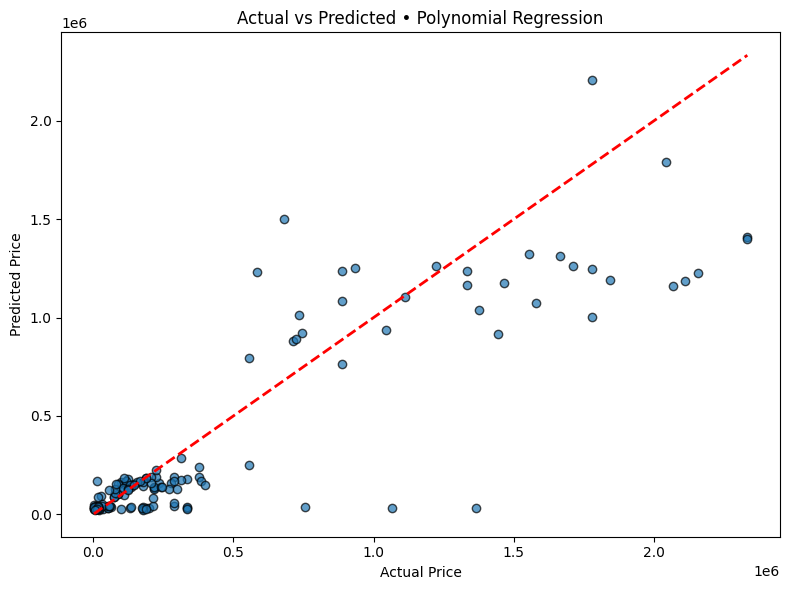


Polynomial Regression
Mean absolute error:  165167.28253873554
Mean squared error:   87990078995.00598
R2 score is:  0.7473582046790181

Ridge Regression
Mean absolute error:  165563.43836249976
Mean squared error:   88460306424.06378
R2 score is:  0.7460080626716098

Lasso Regression
Mean absolute error:  167299.57657834498
Mean squared error:   90341096344.73376
R2 score is:  0.7406078386053643

Best model (TEST):
Mean absolute error:  165167.28253873554
Mean squared error:   87990078995.00598
R2 score is:  0.7473582046790181

Best model (TRAIN):
Mean absolute error:  198746.76439205554
Mean squared error:   157030346881.3331
R2 score is:  0.6189068260423055


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import joblib

# ---------- Helpers ----------
def evaluate_metrics(y_true, y_pred, name):
    mae  = mean_absolute_error(y_true, y_pred)
    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2   = r2_score(y_true, y_pred)
    return {"Model": name, "MAE": mae, "MSE": mse, "RMSE": rmse, "R2": r2}

def pretty_block(y_true, y_pred):
    """3-line console block like your screenshot."""
    print(f"Mean absolute error:  {mean_absolute_error(y_true, y_pred)}")
    print(f"Mean squared error:   {mean_squared_error(y_true, y_pred)}")
    print(f"R2 score is:  {r2_score(y_true, y_pred)}")

# ---------- Load & clean ----------
df = pd.read_csv("FinalCleanedOk.csv")
df.columns = [c.strip() for c in df.columns]

target = "Price_USD" if "Price_USD" in df.columns else (
         "Purchase_Price" if "Purchase_Price" in df.columns else None)
if target is None:
    raise ValueError("Target column not found (expected 'Price_USD' or 'Purchase_Price').")

df[target] = (
    df[target].astype(str)
      .str.replace(",", "", regex=False)
      .str.replace("$", "", regex=False)
      .str.replace("USD", "", regex=False)
      .str.strip()
)
df[target] = pd.to_numeric(df[target], errors="coerce")
df.dropna(subset=[target], inplace=True)
print(f"Records after target cleaning: {len(df)}")

# ---------- Outlier removal ----------
Q1, Q3 = df[target].quantile([0.25, 0.75])
IQR = Q3 - Q1
lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
df_clean = df[(df[target] >= lower) & (df[target] <= upper)].copy()
if len(df_clean) == 0:
    df_clean = df.copy()
print(f"Records after outlier filter: {len(df_clean)}")

# ---------- Features ----------
amenity_cols = ["Swimming Pool", "Security", "Gym", "Has_Elevator", "Has_Parking"]
for col in amenity_cols:
    if col not in df_clean.columns:
        df_clean[col] = 0

df_clean["Total_Amenities"] = df_clean[amenity_cols].sum(axis=1)
township_cols = ["Bahan", "Lanmadaw", "Yankin", "South Oakklar", "Hlaing", "Sanchaung"]

base_features = ["Total_Area_squft", "Bedrooms", "Bathrooms", "Total_Amenities"]
features = [f for f in base_features if f in df_clean.columns] + \
           [t for t in township_cols if t in df_clean.columns]

X = df_clean[features].copy()
y = df_clean[target].copy()

# ---------- Split ----------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)
y_train_log = np.log1p(y_train)

# Save mean values for Flask fallback
joblib.dump(X_train.mean().to_dict(), "X_train_mean.pkl")

# ---------- Pipelines ----------
pipe_poly = Pipeline([
    ("scaler", StandardScaler()),
    ("poly",   PolynomialFeatures(include_bias=False)),
    ("model",  LinearRegression())
])

pipe_ridge = Pipeline([
    ("scaler", StandardScaler()),
    ("poly",   PolynomialFeatures(include_bias=False)),
    ("model",  Ridge(max_iter=20000))
])

pipe_lasso = Pipeline([
    ("scaler", StandardScaler()),
    ("poly",   PolynomialFeatures(include_bias=False)),
    ("model",  Lasso(max_iter=20000))
])

# ---------- Hyperparameter grids ----------
grid_poly  = { "poly__degree": [1, 2, 3] }
grid_ridge = { "poly__degree": [1, 2, 3], "model__alpha": [0.1, 1.0, 10.0, 50.0, 100.0] }
grid_lasso = { "poly__degree": [1, 2, 3], "model__alpha": [0.001, 0.01, 0.1, 1.0, 10.0] }

# ---------- Train ----------
print("Training Polynomial Regression...")
gs_poly = GridSearchCV(pipe_poly, grid_poly, cv=5, scoring="r2", n_jobs=-1)
gs_poly.fit(X_train, y_train_log)

print("Training Ridge Regression...")
gs_ridge = GridSearchCV(pipe_ridge, grid_ridge, cv=5, scoring="r2", n_jobs=-1)
gs_ridge.fit(X_train, y_train_log)


print("Training Lasso Regression...")
gs_lasso = GridSearchCV(pipe_lasso, grid_lasso, cv=5, scoring="r2", n_jobs=-1)
gs_lasso.fit(X_train, y_train_log)

models = {
    "Polynomial Regression": gs_poly.best_estimator_,
    "Ridge Regression": gs_ridge.best_estimator_,
    "Lasso Regression": gs_lasso.best_estimator_
}

# ---------- Evaluate ----------
metrics = []
for name, est in models.items():
    y_pred_log = est.predict(X_test)
    y_pred = np.expm1(y_pred_log)
    m = evaluate_metrics(y_test, y_pred, name)
    metrics.append(m)
    print(f"{name:>22} | R2={m['R2']:.4f}  MAE={m['MAE']:.0f}  MSE={m['MSE']:.0f}  RMSE={m['RMSE']:.0f}")

# ---------- Metrics table ----------
metrics_df = pd.DataFrame(metrics).sort_values("R2", ascending=False).reset_index(drop=True)
print("\n=== Test Metrics (sorted by R2) ===")
print(metrics_df.to_string(index=False, formatters={
    "MAE":  lambda x: f"{x:,.0f}",
    "MSE":  lambda x: f"{x:,.0f}",
    "RMSE": lambda x: f"{x:,.0f}",
    "R2":   lambda x: f"{x:.4f}"
}))
metrics_df.to_csv("model_metrics.csv", index=False)

# ---------- Save best ----------
best_name = metrics_df.iloc[0]["Model"]
best_model = models[best_name]
joblib.dump(best_model, "condo_price_model.pkl")
joblib.dump(list(X_train.columns), "model_columns.pkl")
print(f"Best model: {best_name} -> condo_price_model.pkl")
print("Saved model + model_columns.pkl")

# ---------- Plot best ----------
y_pred_best = np.expm1(best_model.predict(X_test))
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_best, alpha=0.7, edgecolors="k")
lo, hi = min(y_test.min(), y_pred_best.min()), max(y_test.max(), y_pred_best.max())
plt.plot([lo, hi], [lo, hi], "r--", lw=2)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title(f"Actual vs Predicted • {best_name}")
plt.tight_layout()
plt.show()

# ---------- Extra: print like your screenshot ----------
# A) For each model (TEST set)
for name, est in models.items():
    print(f"\n{name}")
    pretty_block(y_test, np.expm1(est.predict(X_test)))

# B) For the BEST model (TEST then TRAIN) in the same 3-line style
print("\nBest model (TEST):")
pretty_block(y_test, y_pred_best)

print("\nBest model (TRAIN):")
pretty_block(y_train, np.expm1(best_model.predict(X_train)))